In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nagavaishnavis","key":"5a35a410ea18956896f7dadefe666489"}'}

In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d aayush9753/image-colorization-dataset
!unzip -q image-colorization-dataset.zip -d /content/image-colorization-dataset


Dataset URL: https://www.kaggle.com/datasets/aayush9753/image-colorization-dataset
License(s): unknown
 95% 450M/473M [00:03<00:00, 58.3MB/s]
100% 473M/473M [00:03<00:00, 146MB/s] 


In [15]:
!ls /content/image-colorization-dataset/data | head

test_black
test_color
train_black
train_color


In [24]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import glob
import torchvision.transforms as transforms

class ColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform=None):
        self.grayscale_images = sorted(glob.glob(os.path.join(grayscale_dir, '*.jpg')))
        self.color_images = sorted(glob.glob(os.path.join(color_dir, '*.jpg')))
        self.transform = transform
        print(f"Found {len(self.grayscale_images)} grayscale and {len(self.color_images)} color images.")

    def __len__(self):
        return min(len(self.grayscale_images), len(self.color_images))

    def __getitem__(self, idx):
        gray_image = Image.open(self.grayscale_images[idx]).convert('L')
        color_image = Image.open(self.color_images[idx]).convert('RGB')

        if self.transform:
            gray_image = self.transform(gray_image)
            color_image = self.transform(color_image)

        gray_image = gray_image[0:1, :, :]  # keep grayscale as 1 channel
        return gray_image, color_image

# Define transform: Resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create training dataset and dataloader
dataset = ColorizationDataset(
    grayscale_dir='/content/image-colorization-dataset/data/train_black',
    color_dir='/content/image-colorization-dataset/data/train_color',
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


Found 5000 grayscale and 5000 color images.


In [25]:
import torch.nn as nn

class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define model (use your model class)
model = ColorizationNet()  # replace with actual model class
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training parameters
num_epochs = 2
max_batches_per_epoch = 5  # limit batches per epoch for quick training

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (gray, color) in enumerate(dataloader):
        if i >= max_batches_per_epoch:
            break  # train only on a few batches per epoch

        gray = gray.to(device)
        color = color.to(device)

        # If grayscale is not 1-channel, fix shape
        gray = gray[:, 0:1, :, :]

        # Forward
        output = model(gray)
        loss = criterion(output, color)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch+1}] Average Loss: {running_loss / max_batches_per_epoch:.4f}")


Using device: cpu
Epoch [1/2], Step [1], Loss: 0.4124
Epoch [1/2], Step [2], Loss: 0.2486
Epoch [1/2], Step [3], Loss: 0.3128
Epoch [1/2], Step [4], Loss: 0.1516
Epoch [1/2], Step [5], Loss: 0.1159
Epoch [1] Average Loss: 0.2483
Epoch [2/2], Step [1], Loss: 0.0449
Epoch [2/2], Step [2], Loss: 0.0746
Epoch [2/2], Step [3], Loss: 0.0720
Epoch [2/2], Step [4], Loss: 0.0603
Epoch [2/2], Step [5], Loss: 0.0355
Epoch [2] Average Loss: 0.0575


In [33]:
test_dataset = ColorizationDataset(
    grayscale_dir='/content/image-colorization-dataset/data/test_black',
    color_dir='/content/image-colorization-dataset/data/test_color',
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


Found 739 grayscale and 739 color images.


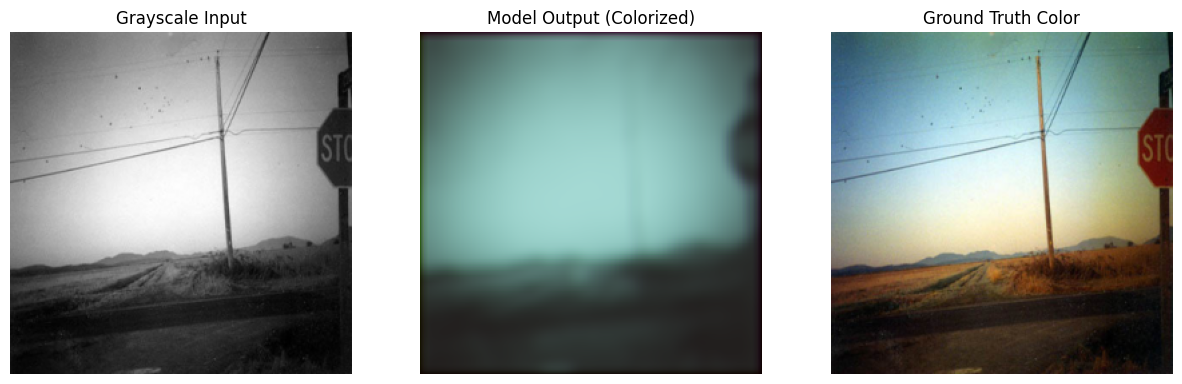

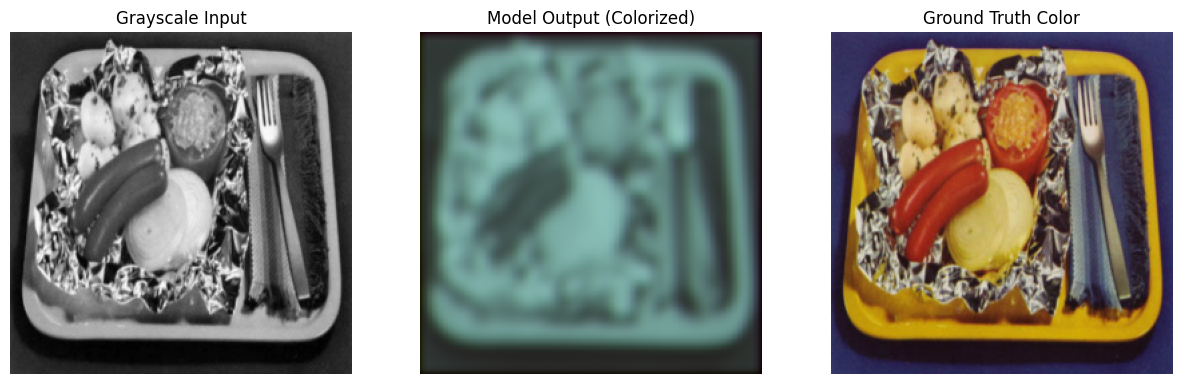

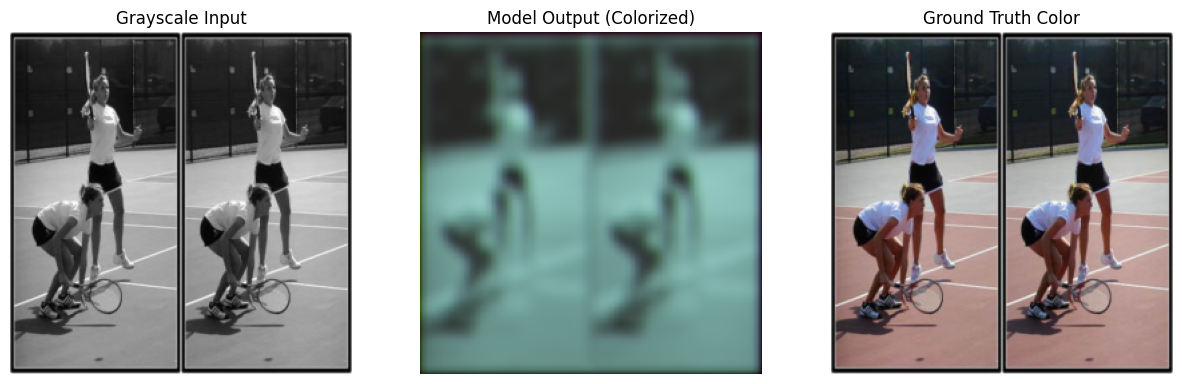

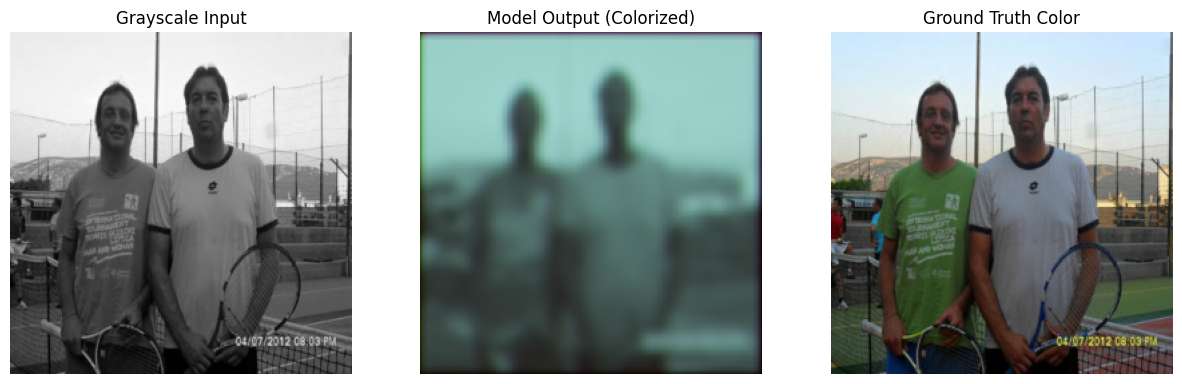

In [34]:
import matplotlib.pyplot as plt
import torch

# Put model in evaluation mode
model.eval()

# Load one batch of test images
for gray, color in test_loader:  # use your test_loader defined earlier
    gray = gray.to(device)
    color = color.to(device)

    with torch.no_grad():
        output = model(gray)

    # Convert tensors to numpy arrays for plotting
    gray_np = gray.cpu().numpy()
    color_np = color.cpu().numpy()
    output_np = output.cpu().numpy()

    # Display first 4 examples side-by-side
    for i in range(min(4, gray_np.shape[0])):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(gray_np[i][0], cmap='gray')
        axs[0].set_title("Grayscale Input")
        axs[0].axis('off')

        axs[1].imshow(output_np[i].transpose(1, 2, 0).clip(0, 1))
        axs[1].set_title("Model Output (Colorized)")
        axs[1].axis('off')

        axs[2].imshow(color_np[i].transpose(1, 2, 0))
        axs[2].set_title("Ground Truth Color")
        axs[2].axis('off')

        plt.show()
    break  # Show only one batch
